# CSE 152: Intro to Computer Vision - Spring 2019 Assignment 3
## Instructor: David Kriegman
### Assignment published on Thursday, May 16, 2019
### Due on Monday, May 27, 2019 at 11:59pm

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook. Show your work for written questions.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

## 1. Photometric Stereo, Specularity Removal [15 pts]

The goal of this problem is to implement a couple of different algorithms that reconstruct a surface using the concept of Lambertian photometric stereo. On top of this, you will implement a robust version of photometric stereo which uses thresholding to address the shadowy/specular parts of images that Lambertian photometric stereo would typically struggle to deal with on its own.

You should assume a Lambertian reflectance function when writing the core photometric stereo process, although later you will have to deal with images of objects with specularities. Note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image.

### Data
You will use synthetic images and specular sphere images as data. These images are stored in `.pickle` files which were graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.

### 1a. Photometric Stereo [10 pts]

Implement the photometric stereo technique described in the lecture slides and in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*). Your program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. You should first try the naive scanline-based "shape by integration" method described in the book and in lecture. (You are required to implement this.) If this does not work well on real images, you can also use the implementation of the Horn integration technique given below in `horn_integrate` function. Note that you will typically want to run the `horn_integrate` function with 10000 - 100000 iterations, meaning it will take a while.

You will find all the data for this part in `synthetic_data.pickle`. Try using only `im1`, `im2` and `im4` first. Display your outputs as mentioned below.

Then use all four images (most accurate).

For **each** of the **two above cases** you must output:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing components of surface normal.

1. A wireframe of depth map.

An example of outputs is shown in the figure below.

![Problem1 example](Problem1 example.png)

Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


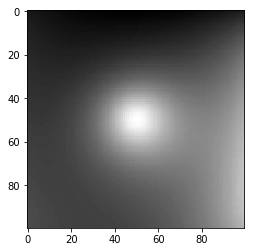

Light source direction: [[0 0 1]]


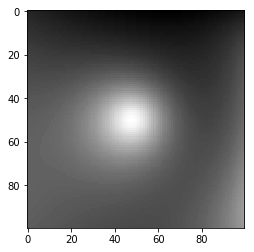

Light source direction: [[0.2 0.  1. ]]


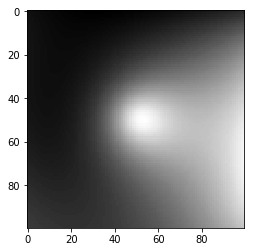

Light source direction: [[-0.2  0.   1. ]]


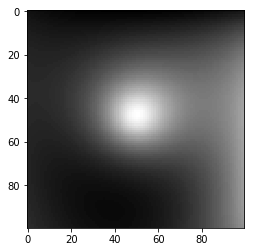

Light source direction: [[0.  0.2 1. ]]


In [1]:
## Example: How to read and access data from a pickle
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))

plt.imshow(data["im2"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l2"]))

plt.imshow(data["im3"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l3"]))

plt.imshow(data["im4"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l4"]))

In [2]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [3]:
def photometric_stereo(images, lights, mask, horn_niter=25000):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale and thresholding
    (only using locations for which the pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 tends to work well.
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))
    H = np.ones(images[0].shape)
    H_horn = np.ones(images[0].shape)
    
    #===========================================================================
    
    for i in range(images[0].shape[0]):
        for j in range(images[0].shape[1]):
            b_ij = np.linalg.multi_dot([np.linalg.inv(np.dot(lights.T,lights)),lights.T, images[:,i,j]])
            albedo[i,j] = np.linalg.norm(b_ij)
            normals[i,j,:] = b_ij / albedo[i,j]
    
    p = -normals[:,:,0] / normals[:,:,2]
    q = -normals[:,:,1] / normals[:,:,2]
    
    p = p*mask
    q = q*mask
    
    
    H_horn = horn_integrate(-p, -q, mask, horn_niter)
    
#     H[0,0] = 0
#     for i in range(1,H.shape[0]):
#         H[i,0] = H[i-1,0] - q[i,0]
    
#     for i in range(H.shape[0]):
#         for j in range(1,H.shape[1]):
#             H[i,j] = H[i,j-1] - p[i,j]
        
    q[0,0] = 0
    q[:,0] = -np.cumsum(q[:,0])
    p = -p
    p[:,0] = q[:,0]
    for i in range(H.shape[0]):
        H[i,:] = np.cumsum(p[i,:])
    
#     H=H*mask
    
    return albedo, normals, H, H_horn

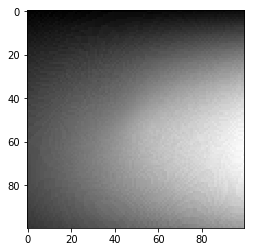

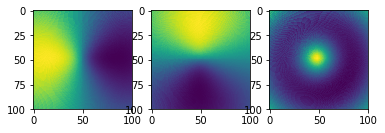

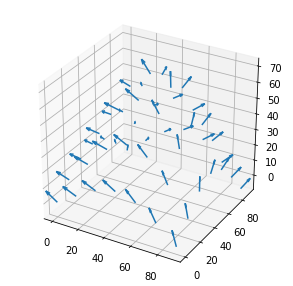

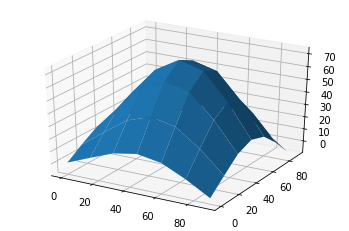

In [4]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))
# lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
# images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask)

# --------------------------------------------------------------------------
# The following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout. You are also free to change the function
# however you wish; just make sure you get all of the required outputs.
# --------------------------------------------------------------------------

def visualize(albedo, normals, depth, horn):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map
    H = depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

visualize(albedo, normals, depth, horn)

### 1b. Specularity Removal [5 pts]

Now we will use an image of a sphere which includes specularities, violating our Lambertian assumption. There are several established methods to deal with such cases, but for the purposes of this homework we will use one of the simpler ones. Namely, we will identify "specular" or "shadow" outliers in terms of brightness values at different locations (by comparing each image pixel's value to a global threshold) and remove them by either (a) clamping them to a threshold value or (b) setting them to the median of a sizable window around each given location.

Normally, you might handle these extreme values by simply not using the corresponding source in your estimation of the surface normal at that pixel. However, in our case we only have four different images, and we need three to perform photometric stereo. So we are only able to remove one image at most, and in some cases we might still end up with a source or two which still have the extreme values, leading to noisy results still. Therefore we will instead go with the two methods described earlier.

**You will find all the data for this part in `specular_sphere.pickle`.** First, for comparison, run your photometric stereo code from 1a on the original images (converted to grayscale and rescaled/shifted to be in the range [0, 1]). You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption.

Show the same outputs as in 1a.

stereoing


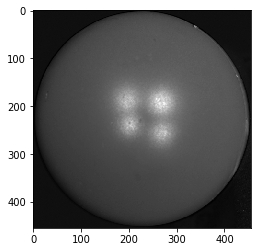

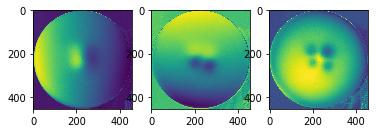

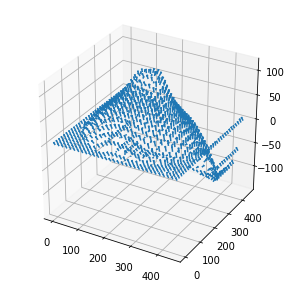

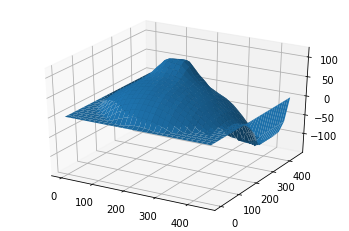

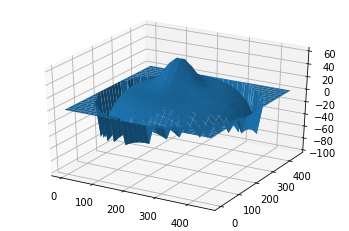

In [5]:
def grayscale(img):
    """Converts RGB image to grayscale."""
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def normal_img(img):
    norm_img = (img-img.min())/(img.max()-img.min())
    return norm_img
# ---------------------------------------------------------------------------
# You may reuse the code for photometric_stereo here.
# Write your code below to process the data and send it to photometric_stereo
# and display the albedo, normals and depth maps.
# ---------------------------------------------------------------------------

pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
# print("Keys: " + str(data.keys())) 

# lights = np.vstack((data["l1"], data["l2"], data["l4"]))
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
gray_im1 = grayscale(data["im1"])
gray_im2 = grayscale(data["im2"])
gray_im3 = grayscale(data["im3"])
gray_im4 = grayscale(data["im4"])
norm_im1 = normal_img(gray_im1)
norm_im2 = normal_img(gray_im2)
norm_im3 = normal_img(gray_im3)
norm_im4 = normal_img(gray_im4)

images.append(norm_im1)
images.append(norm_im2)
images.append(norm_im3)
images.append(norm_im4)
images = np.array(images)

threshold = 0.11
mask = (norm_im1+norm_im2+norm_im3+norm_im4)/4
mask[mask<=threshold]=0
mask[mask>threshold]=1

print("stereoing")
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, horn_niter=10000)
visualize(albedo, normals, depth, horn)


---

Our goal will be to remove these bumps or sharp parts in the reconstruction.

Implement the `robust_photometric_stereo` function which performs photometric stereo as before, but which also takes in a low threshold and a high threshold and does one of two things depending on the `median` flag:

  - **If `median` is False:** for any values in any source that fall outside the low or high threshold, sets all of those values at their corresponding locations (in the offending source) to the thresholds that they violated. For example, if the threshold is 0.6 and one of the sources has a value which is 0.65, that value should be clamped to 0.6. This should be a small addition to your `photometric_stereo` function.
  
  - **If `median` is True:** for any values in any source that fall outside the low or high threshold, sets all of those values at their corresponding locations (in the offending source) to the median of the surrounding window, or to the closest threshold if the median still falls outside of a threshold. You are free to experiment with the window size, but we suggest you use something around 200.

For the specular sphere image set in `specular_sphere.pickle`, using all of the four images (again, be sure to convert them to grayscale and rescale/offset them so that their values go from 0 to 1), include:

1. The estimated albedo map (original and diffuse)

1. The estimated surface normals (original and diffuse) by showing both

    1. Needle map, and
    1. Three images showing components of surface normal
    
1. A wireframe of depth map (original and diffuse)

Do this while running your `robust_photometric stereo` function for both `median` set to `True` and `median` set to `False`. In other words, you will run `robust_photometric_stereo` twice in total on the same specular sphere data, and you should show all of these outputs both times. You should notice less of an effect of the bump(s) caused by the specularities. We suggest you use a `low_thres` of 0.0 and a `high_thres` of 0.4.

In [6]:
def zero_pad(image, pad_top, pad_down, pad_left, pad_right):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_top = 1, pad_down = 1, pad_left = 2, pad_right = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W)
        pad_width: width of the zero padding (left and right padding)
        pad_height: height of the zero padding (bottom and top padding)

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width)
    """

    H, W = image.shape
    out = np.zeros((H + pad_top + pad_down, W + pad_left + pad_right))
    if pad_down==0 or pad_right==0:
        if pad_down==0 and pad_right==0:
            out = image
        elif pad_right!=0:
            out[pad_top:,pad_left:-pad_right] = image
        else:
            out[pad_top:-pad_down,pad_left:] = image 
    else:
        out[pad_top:-pad_down,pad_left:-pad_right] = image
    
    return out

stereoing1


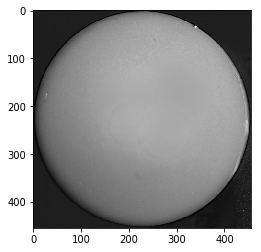

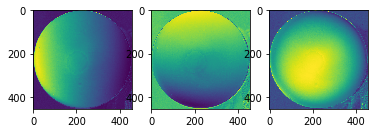

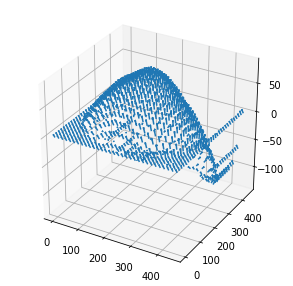

stereoing2


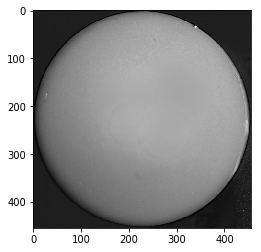

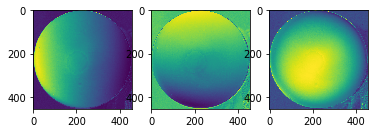

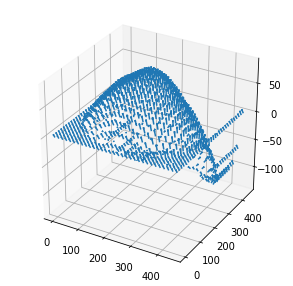

In [7]:
def robust_photometric_stereo(images, lights, mask, low_thres, high_thres, median, horn_niter=25000):

    """ ==========
    YOUR CODE HERE
    ========== """
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))
    H = np.ones(images[0].shape)
    H_horn = np.ones(images[0].shape)
    
    #==========================================================================
    
    if median == False:
        images[images<low_thres] = low_thres
        images[images>high_thres] = high_thres
    
    else:
        windowSize = 101
        padd_size = (int)(windowSize/2)
        for n in range(images.shape[0]):
            padd_img = zero_pad(images[n,:,:],padd_size,padd_size,padd_size,padd_size)
            h = padd_img.shape[0]
            w = padd_img.shape[1]
            for i in range(0,h-windowSize):
                for j in range(0,w-windowSize):
                    point = padd_img[i+padd_size,j+padd_size]
                    if point<low_thres or point>high_thres:
                        window_med = np.median(padd_img[i:i+windowSize,j:j+windowSize])
                        if window_med<low_thres:
                            images[n,i,j] = low_thres
                        elif window_med>high_thres:
                            images[n,i,j] = high_thres
                        else:
                            images[n,i,j] = window_med
        
    
    for i in range(images[0].shape[0]):
        for j in range(images[0].shape[1]):
            b_ij = np.linalg.multi_dot([np.linalg.inv(np.dot(lights.T,lights)),lights.T, images[:,i,j]])
            albedo[i,j] = np.linalg.norm(b_ij)
            normals[i,j,:] = b_ij / albedo[i,j]
    
    p = -normals[:,:,0] / normals[:,:,2]
    q = -normals[:,:,1] / normals[:,:,2]
    
    p = p*mask
    q = q*mask
    
    H_horn = horn_integrate(-p, -q, mask, horn_niter)
    
    q[0,0] = 0
    q[:,0] = -np.cumsum(q[:,0])
    p = -p
    p[:,0] = q[:,0]
    for i in range(H.shape[0]):
        H[i,:] = np.cumsum(p[i,:])

    return albedo, normals, H, H_horn

# ----------------------------------------------------------------------------------
# Write your code below to process the data, send it to robust_photometric_stereo,
# and display the albedo, normals and depth maps.
# ----------------------------------------------------------------------------------

pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# lights = np.vstack((data["l1"], data["l2"], data["l4"]))
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
gray_im1 = grayscale(data["im1"])
gray_im2 = grayscale(data["im2"])
gray_im3 = grayscale(data["im3"])
gray_im4 = grayscale(data["im4"])
norm_im1 = normal_img(gray_im1)
norm_im2 = normal_img(gray_im2)
norm_im3 = normal_img(gray_im3)
norm_im4 = normal_img(gray_im4)

images.append(norm_im1)
images.append(norm_im2)
images.append(norm_im3)
images.append(norm_im4)
images = np.array(images)

threshold = 0.11
mask = (norm_im1+norm_im2+norm_im3+norm_im4)/4
mask[mask<=threshold]=0
mask[mask>threshold]=1

print("stereoing1")
albedo, normals, depth, horn = robust_photometric_stereo(images, lights, mask, low_thres=0.0, high_thres=0.4, median=True, horn_niter=10000)
visualize(albedo, normals, depth, horn)

print("stereoing2")
albedo, normals, depth, horn = robust_photometric_stereo(images, lights, mask, low_thres=0.0, high_thres=0.4, median=False, horn_niter=10000)
visualize(albedo, normals, depth, horn)




## 2. Optical Flow [15 pts]

In this problem, the single scale Lucas-Kanade method for estimating optical flow will be implemented. The data needed for this problem can be found in the folder 'optical_flow_images'.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](optical_flow_images/sample_optical_flow_output.png)

### 2a. Lucas-Kanade implementation [6 pts]

Implement the Lucas-Kanade method for estimating optical flow. The function `LucasKanade` needs to be completed.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

def plot_optical_flow(img, U, V, foeX=None, foeY=None):
    """Plots optical flow given U,V and one of the images."""
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    
    if foeX is not None and foeY is not None:
        plt.scatter(foeX, foeY, s=100, edgecolors='black', facecolors='gold')
        plt.ylim(U.shape[0]-1,0)
        plt.xlim(0,U.shape[1]-1)
    
    plt.show()

images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png'))

In [9]:
def LucasKanade(im1, im2, window):
    """
    Inputs: the two images and window size
    Return U,V
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    U = np.zeros(im1.shape)
    V = np.zeros(im1.shape)
    
    It = im2 - im1
    
    [sy, sx] = np.gradient(im1)
    sy = -sy
    Ixx = sx**2
    Iyy = sy**2
    Ixy = sx*sy
    Ixt = -sx*It
    Iyt = -sy*It
    
    temp = int(window/2)
    sum_kern = np.ones([window,window])
    
    im_Ixx = conv2(Ixx, sum_kern, boundary='fill', mode='same')
    im_Iyy = conv2(Iyy, sum_kern, boundary='fill', mode='same')
    im_Ixy = conv2(Ixy, sum_kern, boundary='fill', mode='same')
    im_Ixt = conv2(Ixt, sum_kern, boundary='fill', mode='same')
    im_Iyt = conv2(Iyt, sum_kern, boundary='fill', mode='same')
    
    for row in range(Ixx.shape[0]): 
        for col in range (Ixx.shape[1]):
            C = np.zeros([2,2])
            C[0][0] = im_Ixx[row,col]
            C[1][0] = im_Ixy[row,col]
            C[0][1] = C[1][0]
            C[1][1] = im_Iyy[row,col]
            
            B = np.zeros([2,1])
            B[0][0] = im_Ixt[row,col]
            B[1][0] = im_Iyt[row,col]
            U[row][col],V[row][col] = np.dot(np.linalg.pinv(C),B)
    
    return U,V

### 2b. Window size [3 pts]

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which lead to observable differences in the results. Comment on the effect of window size on your results and provide justification for your statement(s).

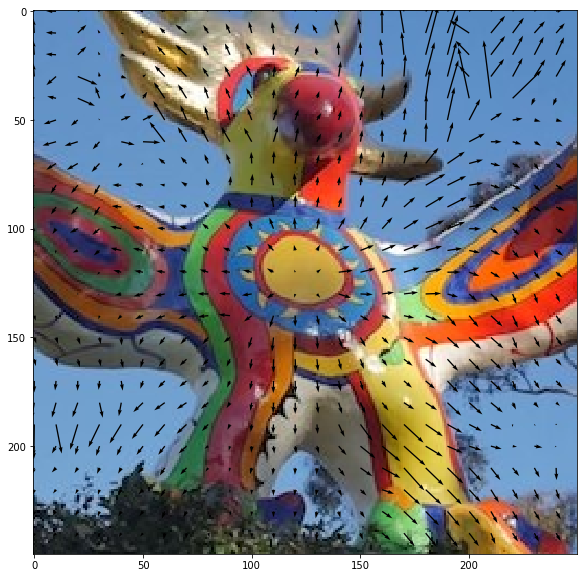

In [10]:
window = 50
sun1 = plt.imread('sungod1.jpg')
sun2 = plt.imread('sungod2.jpg')
U,V=LucasKanade(grayscale(sun1), grayscale(sun2), window)
plot_optical_flow(sun1, U, V)

window = 90
sun1 = plt.imread('sungod1.jpg')
sun2 = plt.imread('sungod2.jpg')
U,V=LucasKanade(grayscale(sun1), grayscale(sun2), window)
plot_optical_flow(sun1, U, V)

window = 170
sun1 = plt.imread('sungod1.jpg')
sun2 = plt.imread('sungod2.jpg')
U,V=LucasKanade(grayscale(sun1), grayscale(sun2), window)
plot_optical_flow(sun1, U, V)

In [18]:
# Example code, change as required

""" ==========
YOUR CODE HERE
========== """
window = [30,60,100,140]
for w in window:
    U,V=LucasKanade(grayscale(images[0]), grayscale(images[1]), w)
    plot_optical_flow(images[0], U, V)

### Your answer to 2b here...

In [ ]:
'''
for window size too small the motion flow's direction looks disordered 
and the magnitude is disordered as well, jumping too high and too low 
at different places
for window size too big, the motion flow has gaps and is not consistent
'''

### 2c. All pairs [3 pts]

Find optical flow for the pairs (im1,im2), (im1,im3), (im1,im4) using a good window size. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

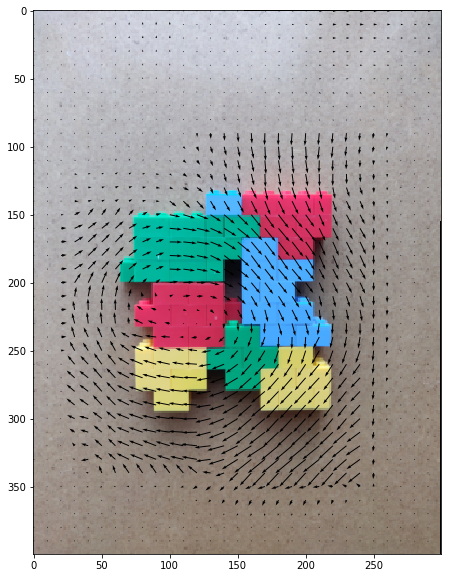

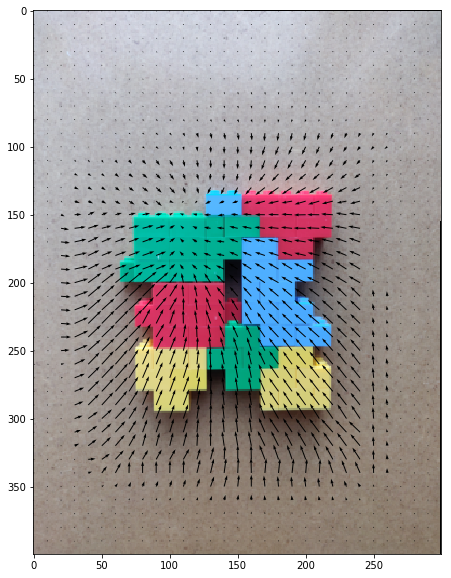

In [19]:
""" ==========
YOUR CODE HERE
========== """
w = 100
for i in range(1,4):
    U,V=LucasKanade(grayscale(images[0]), grayscale(images[i]), w)
    plot_optical_flow(images[0], U, V)      

### Your answer to 2c here...

In [ ]:
'''
the first two images looks consistent with the motion
shifting the the left and rotating clockwise
however the third image's motion field is inconsistent
predicting inward motion, this is the result of lighting
the lighting intensity reduces in the center and appears that the image
has inward motion
'''

### 2d. Analysis [3 pts]

Give a short analysis on potential causes of failure (name at least three) in general for the Lucas-Kanade optical flow method. Also provide a possible solution to fix each of these problems.

In [ ]:
'''
1. sometimes motion flow exists, but no optical flow, since an 
object might move but the consistent surface may result in same 
optical flow ex: a sphere with smooth surface has same lighting 
when it rotates 
-> add background which doen't have this problem, estimate the motion

2. the aperture effect, optical field not same as motion field 
due to small view
-> view image 

3. since our assumption is that motion is small and consistent within
window, window size is an essential factor, and will effect our prediction
-> use validation to select best window 

'''

### Your answer to 2d here...

## 3. RANSAC for Estimating the Focus of Expansion [10 pts]

In this problem, you will perform RANSAC to estimate the focus of expansion in the first of two images which are related by a camera translation.

### 3a. Initial Focus of Expansion Estimation

First, compute and plot the optical flow for the pair of images `entryway1.jpg` and `entryway2.jpg`, **using a window size of 100**. Estimate the focus of expansion for the motion field as the location where the optical flow vector has the smallest magnitude, and plot this on top of the optical flow field. Comment on the result you get; does it seem accurate? If not, provide an hypothesis as to why it doesn't work.

entryway1


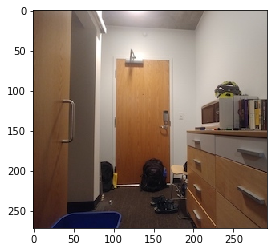

entryway2


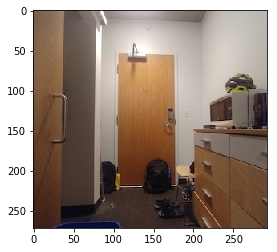

Estimated focus of expansion is (y, x) = (258, 268)


In [22]:
entryway1 = plt.imread('entryway1.jpg')
entryway2 = plt.imread('entryway2.jpg')

# ----------------------------------------------------------------------------------
# Write your code below to plot the optical flow from the `entryway1` image to the `entryway2` image,
# plotted on top of the `entryway1` image. The code should be very similar to that which you've
# written or seen a little earlier in this file.
# 
# Also estimate and plot the focus of expansion as the location corresponding
# to the flow vector with the smallest magnitude. You can use the foeX and foeY parameters
# of `plot_optical_flow` for plotting the focus of expansion.
#
# You can delete the code below; it's just so you can see what the images look like.
# ----------------------------------------------------------------------------------

print('entryway1')
plt.imshow(entryway1)
plt.show()
print('entryway2')
plt.imshow(entryway2)
plt.show()

foeY, foeX = 0, 0
window = 100
U,V=LucasKanade(grayscale(entryway1), grayscale(entryway2), window)

sqr_sum = U**2 + V**2
foeX,foeY = np.unravel_index(sqr_sum.argmin(),(sqr_sum.shape[0],sqr_sum.shape[1]))
plot_optical_flow(entryway1, U, V, foeX,foeY)
# print(sqr_sum[foeX,foeY])
# print(sqr_sum.min())

print('Estimated focus of expansion is (y, x) = (%d, %d)' % (foeY, foeX))

In [23]:
'''
estimate the FOE by finding the location where the of U,V norm is the
smallest, which is not accurate since the motion is not consistent 
in the whole image, so some parts may have small magnitude motion,
so the smallest magnitude point may not be at the FOE location
'''

'\nestimate the FOE by finding the location where the of U,V norm is the\nsmallest, which is not accurate since the motion is not consistent \nin the whole image, so some parts may have small magnitude motion,\nso the smallest magnitude point may not be at the FOE location\n'

### 3b. Estimating the Focus of Expansion with RANSAC

Next, use RANSAC to estimate the focus of expansion. Implement the function `foe_RANSAC` which should run optical flow on the two provided images, then [in a RANSAC framework similar to that of HW2] continually (a) sample two different flow vectors, (b) estimate the focus of expansion as the intersection of the flow vectors, and (c) check the consistency of this estimate across all of the flow vectors (based on the distance of the proposed focus of expansion from each of the lines represented by the flow vectors).

There is no need to recompute everything (like you did for the fundamental matrix) at the end of all of the iterations. You are free to tune the parameters as you wish. You are also free, when checking inliers, to only use a subset of the flow vectors (e.g. the ones that are actually plotted, maybe the flow vector at every 10 grid points). This might help speed things up and should not degrade results unless you subsample massively.

Number of inliers as iteration increases:


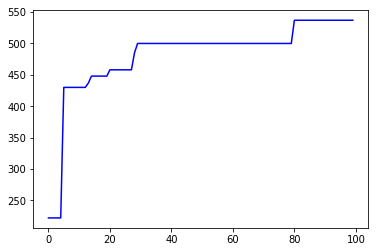

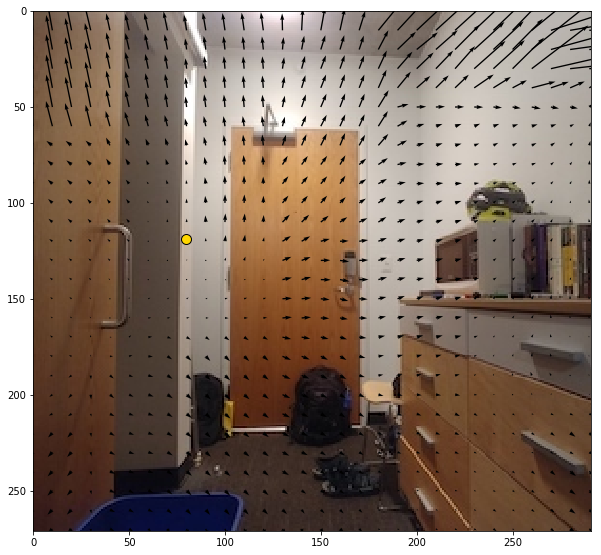

Estimated focus of expansion is (y, x) = (119, 79)


In [25]:
from tqdm import tqdm

def dis_point_vec(a,n,p):
    n = n/np.linalg.norm(n)
    return np.linalg.norm((a-p)-np.sum((a-p)*n)*n)


def foe_RANSAC(im1, im2, distThreshold, nSample):
    import random
    """
    Inputs: 
      - im1, im2: two images which are related by a camera translation
      - distThreshold: distance threshold to use for inlier determination
      - nSample: number of iterations to run
    
    Return values:
      - foeX, foeY: coordinates of estimated focus of expansion
      - bestInliersIdxX, bestInliersIdxY: coordinates of inliers in max-size set
      - bestInliersNumList: list of highest number of inliers so far (at each of nSamples iterations)
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """

    bestFOE = [0, 0]
    bestInliersIdxX = []
    bestInliersIdxY = []
    bestInliersNum = 0
    bestInliersNumList = []
    #==================================================================================
    window = 100
    U,V=LucasKanade(grayscale(entryway1), grayscale(entryway2), window)

    h,w = U.shape
    x = np.arange(0,h,10)
    y = np.arange(0,w,10)
    xx,yy = np.meshgrid(x,y)
    xy_cords = np.stack((xx,yy),axis=-1).reshape(-1,2)
    
    max_count = -1
    bestInliersNumList = []
    for i in range(nSample):
        count = 0
        inliersIdxX = []
        inliersIdxY = []
        
        rand2x = np.random.choice(h,2)
        rand2y = np.random.choice(w,2)
        rand_pt1 = np.array([rand2x[0],rand2y[0]])
        rand_pt2 = np.array([rand2x[1],rand2y[1]])
    
        
        a = np.array([[V[rand_pt1[0],rand_pt1[1]],V[rand_pt2[0],rand_pt2[1]]],\
                      [U[rand_pt1[0],rand_pt1[1]],U[rand_pt2[0],rand_pt2[1]]]])
        b = np.array([rand2x[1]-rand2x[0],rand2y[1]-rand2y[0]])
        
        
        
        tempFOE = np.linalg.solve(a,b)
        
        for j in range(xy_cords.shape[0]):
            if dis_point_vec(xy_cords[j,:],np.array([V[xy_cords[j,:][0],xy_cords[j,:][1]],\
                U[xy_cords[j,:][0],xy_cords[j,:][1]]]),tempFOE)<distThreshold:
                count+=1
                inliersIdxX.append(xy_cords[j,:][0])
                inliersIdxY.append(xy_cords[j,:][1])
                
        if count>max_count:
            max_count = count
            bestFOE[0] = tempFOE[0]
            bestFOE[1] = tempFOE[1]
        bestInliersNumList.append(max_count)
        
    bestInliersIdxX = inliersIdxX
    bestInliersIdxY = inliersIdxY
        
    return bestFOE[0], bestFOE[1], bestInliersIdxX, bestInliersIdxY, bestInliersNumList

entryway1 = plt.imread('entryway1.jpg')
entryway2 = plt.imread('entryway2.jpg')

# Estimate the focus of expansion using RANSAC
distanceThreshold = 100
nSample = 100
np.random.seed(15)
foeX, foeY, bestInliersIdxX, bestInliersIdxY, bestInliersNumList \
        = foe_RANSAC(entryway1, entryway2, distanceThreshold, nSample)

print('Number of inliers as iteration increases:')
plt.plot(np.arange(len(bestInliersNumList)), bestInliersNumList, 'b-')


# Plot the estimated focus of expansion
plot_optical_flow(entryway1, U, V, foeX,foeY)
print('Estimated focus of expansion is (y, x) = (%d, %d)' % (foeY, foeX))
# ----------------------------------------------------------------------------------
# Write your code to plot the estimated focus of expansion.
# ----------------------------------------------------------------------------------

### 3c. Conceptual Check

What is the difference between a motion field and an optical flow field?

In [ ]:
'''
motion field is the velocity field of the objects,
whereas the optical field is the image intensity field 
shift of the images
'''

---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents in each cell are clearly shown in your final PDF file.

There are multiple options for converting the notebook to PDF:
1. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX
2. You can first export as HTML and then convert to PDF